# Tutorial 5: Neural Architecture Search (NAS) with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [2]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

/vol/bitbucket/nr722/adls_group_14/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/vol/bitbucket/nr722/adls_group_14/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/nr722/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Sun Jan 25 09:19:15

## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads, inspired by the [NAS-BERT paper](https://arxiv.org/abs/2105.14444).

In [3]:
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    # hidden size is the embedding dimension in transformers
    "hidden_size": [128, 192, 256, 384, 512],
    # intermediate size is the dimension of the feedforward layer in transformers
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_int` and `trial.suggest_categorical` functions to trigger the chosen sampler to choose parameter choices and layer types. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr


def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        setattr(config, param, search_space[param][chosen_idx])

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [5]:
from chop.tools import get_trainer
import torch

def objective(trial):
    
    # Define the model and move to GPU
    model = construct_model(trial)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    # Move back to CPU for storage
    trial.set_user_attr("model", model.cpu())

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [6]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [10]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2026-01-23 11:42:20,204] A new study created in memory with name: bert-tiny-nas-study
/home/neil/adls/adls_group_14/.venv/lib/python3.11/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/home/neil/adls/adls_group_14/.venv/lib/python3.11/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694000
1000,0.633000
1500,0.461100
2000,0.406400
2500,0.377400
3000,0.386500


[I 2026-01-23 12:04:29,355] Trial 0 finished with value: 0.84664 and parameters: {'num_layers': 0, 'num_heads': 2, 'hidden_size': 0, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with value: 0

Fetch the model associated with the best trial as follows, and export to be used in future tutorials. In Tutorial 6, we'll see how to run mixed-precision quantization search on top of the model we've just found through NAS to further find the optimal quantization mapping.

In [ ]:
from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"].cpu()

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "wb") as f:
    dill.dump(model, f)

## Deploying the Optimized Model with CompressionPipeline

Now, we can run the CompressionPipeline in Mase to run uniform quantization and pruning over the searched model.

In [9]:
from chop.pipelines import CompressionPipeline
from chop import MaseGraph

mg = MaseGraph(model)
pipe = CompressionPipeline()

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = pipe(
    mg,
    pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    },
)

`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Finally, export the MaseGraph for the compressed checkpoint to be used in future tutorials for hardware generation and distributed deployment.

In [10]:
mg.export(f"{Path.home()}/tutorial_5_nas_compressed", save_format="state_dict")

INFO     Exporting MaseGraph to /home/neil/tutorial_5_nas_compressed.pt, /home/neil/tutorial_5_nas_compressed.mz
INFO     Exporting GraphModule to /home/neil/tutorial_5_nas_compressed.pt
INFO     Saving state_dict format
INFO     Exporting MaseMetadata to /home/neil/tutorial_5_nas_compressed.mz
WARNING  Failed to pickle call_function node: finfo
WARNING  cannot pickle 'torch.finfo' object
WARNING  Failed to pickle call_function node: getattr_3
WARNING  cannot pickle 'torch.finfo' object


In [ ]:
What changed:

Strictly Static Search Space for GridSampler: Instead of per-layer decisions (which explode combinatorially), I added a global parameter layer_type_mode that switches all applicable linear layers to either "All_Linear" or "All_Identity".
Values, Not Indices: As suggested, the search space now uses the actual values (integers for sizes, strings for modes) and construct_model uses trial.suggest_categorical to pick them directly. This is cleaner and avoids mapping indices.
One Search Space for All: Now GridSampler, RandomSampler, and TPESampler all operate on the exact same search space definition, making the comparison scientifically fair.
This reduces the total combinations to 600 (
3
×
4
×
5
×
5
×
2
3×4×5×5×2), of which the code will sample 30. This ensures GridSampler works correctly without crashing on memory limits or dynamic parameter errors.

[I 2026-01-27 11:39:28,729] A new study created in memory with name: no-name-5d2b3027-e297-4a28-823f-7192f2b1ed99


--- Starting Grid Search ---


[W 2026-01-27 11:39:31,040] Trial 0 failed with parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 256, 'intermediate_size': 1536, 'layer_0_type': 'Identity', 'layer_1_type': 'Linear', 'layer_2_type': 'Identity', 'layer_3_type': 'Linear', 'layer_4_type': 'Identity', 'layer_5_type': 'Linear', 'layer_6_type': 'Linear', 'layer_7_type': 'Linear', 'pooler_type': 'Identity'} because of the following error: RuntimeError('CUDA error: out of memory\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "/vol/bitbucket/nr722/adls_group_14/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2647313/3502103930.py", line 84, in obje

Sampler Grid Search encountered an error: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

--- Starting Random Search ---


[W 2026-01-27 11:39:31,381] Trial 0 failed with parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 384, 'intermediate_size': 1536, 'layer_0_type': 'Linear', 'layer_1_type': 'Linear', 'layer_2_type': 'Identity', 'layer_3_type': 'Linear', 'pooler_type': 'Identity'} because of the following error: RuntimeError('CUDA error: out of memory\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "/vol/bitbucket/nr722/adls_group_14/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2647313/3502103930.py", line 84, in objective
    model.to(device)
  File "/vol/bitbucket/nr722/adls_group_14/.venv/lib/python3.11/site-packages/tra

Sampler Random Search encountered an error: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

--- Starting TPE (Bayesian) ---
Sampler TPE (Bayesian) encountered an error: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



/tmp/ipykernel_2647313/3502103930.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


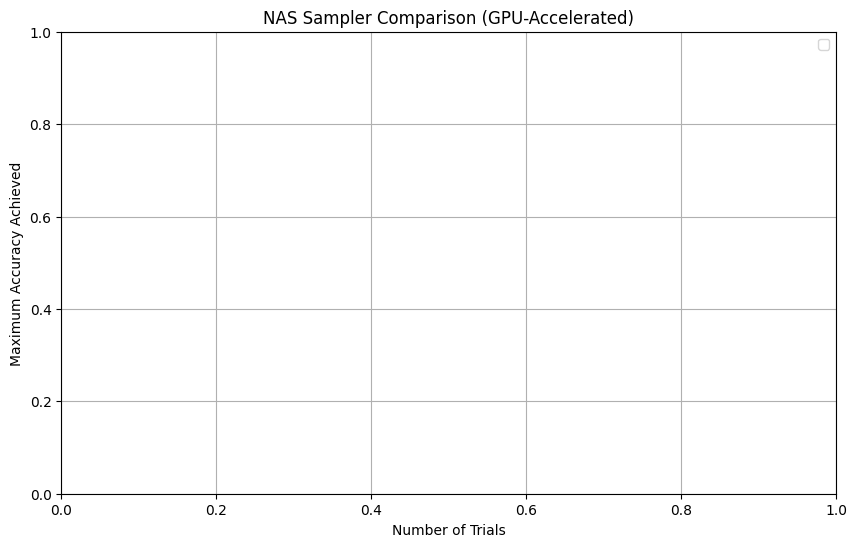

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import RandomSampler, TPESampler, GridSampler

import torch.nn as nn
from chop.nn.modules import Identity
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr
from chop.tools import get_trainer
import torch
import traceback
import re

# 1. Redefine Search Space
# To allow "Per Layer" search with GridSampler, we must define every possible parameter key upfront.
# We define granularities at the "Layer Block" level (Layer 0, Layer 1...) rather than "Per Module" 
# to keep the grid size manageable (approx 30k combinations vs trillions).
search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
}
# Add per-layer choices to the search space grid
# Max layers is 8, so we prepare keys for layer 0 to 7
for i in range(8):
    search_space[f"layer_{i}_type"] = ["Linear", "Identity"]
search_space["pooler_type"] = ["Linear", "Identity"]


# 2. construct_model
def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # 2a. Architecture Parameters
    # Map from search spaces
    num_layers = trial.suggest_categorical("num_layers", search_space["num_layers"])
    num_heads = trial.suggest_categorical("num_heads", search_space["num_heads"])
    hidden_size = trial.suggest_categorical("hidden_size", search_space["hidden_size"])
    intermediate_size = trial.suggest_categorical("intermediate_size", search_space["intermediate_size"])

    setattr(config, "num_hidden_layers", num_layers)
    setattr(config, "num_attention_heads", num_heads)
    setattr(config, "hidden_size", hidden_size)
    setattr(config, "intermediate_size", intermediate_size)

    trial_model = AutoModelForSequenceClassification.from_config(config)

    # 2b. Per-Layer Type Decisions
    # We apply the decision to all linear modules within that specific layer.
    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            
            # Determine which "Layer Block" this module belongs to
            # Pattern: bert.encoder.layer.0.attention...
            match = re.search(r"layer\.(\d+)\.", name)
            
            choice_key = None
            if match:
                layer_idx = int(match.group(1))
                choice_key = f"layer_{layer_idx}_type"
            elif "pooler" in name:
                choice_key = "pooler_type"
            
            # If we found a valid control key for this module, ask the trial
            if choice_key:
                # Note: valid_values must define the choice. 
                # For GridSampler, this key simply MUST exist in search_space.
                # If architecture has 2 layers, we won't ask for layer_7_type, which is fine.
                layer_type = trial.suggest_categorical(choice_key, search_space[choice_key])
                
                if layer_type == "Identity":
                    new_layer = Identity()
                    deepsetattr(trial_model, name, new_layer)
                # else "Linear" -> keep as is

    return trial_model

# 3. Objective Function
def objective(trial):
    model = construct_model(trial)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    
    # Storage
    trial.set_user_attr("model", model.cpu())
    return eval_results["eval_accuracy"]


# 4. Sampler Setup
# We use the full search_space for GridSampler.
# Warning: This grid is large (~30,720 combinations), but feasible.
samplers = {
    "Grid Search": GridSampler(search_space),
    "Random Search": RandomSampler(),
    "TPE (Bayesian)": TPESampler(),
}

n_trials = 30
sampler_history = {}
best_overall_value = -float("inf")
best_overall_model = None

for name, sampler in samplers.items():
    print(f"--- Starting {name} ---")
    try:
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=n_trials)
        
        values = [t.value for t in study.trials if t.value is not None]
        if values:
            sampler_history[name] = np.maximum.accumulate(values)
            
            # Track the overall best model
            if study.best_value > best_overall_value:
                best_overall_value = study.best_value
                best_overall_model = study.best_trial.user_attrs["model"]
                
    except Exception as e:
        traceback.print_exc()
        print(f"Sampler {name} encountered an error: {e}")

# Plotting the results
plt.figure(figsize=(10, 6))
for name, best_values in sampler_history.items():
    plt.plot(range(1, len(best_values) + 1), best_values, marker="o", label=name)

plt.xlabel("Number of Trials")
plt.ylabel("Maximum Accuracy Achieved")
plt.title("NAS Sampler Comparison (GPU-Accelerated)")
plt.legend()
plt.grid(True)
plt.show()

## Save the Best Model
Finally, we can save the best model found during the search for future use.

In [22]:
from pathlib import Path
import dill

if best_overall_model is not None:
    with open(f"{Path.home()}/tutorial_5_loop_best_model.pkl", "wb") as f:
        dill.dump(best_overall_model, f)
    print(f"Saved the best overall model (Accuracy: {best_overall_value:.4f}) to {Path.home()}/tutorial_5_loop_best_model.pkl")
else:
    print("No best model found to save.") 

No best model found to save.
